In [1]:
import copy
import torch
import numpy as np

## Saliency Function

In [2]:
def check_allow_trim(dict):
    res = False
    if "allow_trim" in dict.keys():
        if dict["allow_trim"]:
            res = True
    return res


In [3]:
def group_criteria(list_criteria_per_layer, layers_group, group_size=1):
    '''
    Function combine criteria per neuron into groups of size group_size.
    Output is a list of groups organized by layers. Length of output is a number of layers.
    The criterion for the group is computed as an average of member's criteria.
    Input:
    list_criteria_per_layer - list of criteria per neuron organized per layer
    group_size - number of neurons per group
    layers_group - layers can form a group, e.g. residual connection, they will be pruned together

    Output:
    groups - groups organized per layer. Each group element is a tuple of 2: (index of neurons, criterion)
    groups_unique - groups organized per UNIQUE layers only. Each group element is a tuple of 2: (index of neurons, criterion)
    '''
    assert len(list_criteria_per_layer) == len(layers_group)
    groups = list()

    for layer_indx, layer_criteria in enumerate(list_criteria_per_layer):
        layer = layer_criteria

        if layer_indx == 0:
            group_size = 16
        else:
            if layer_indx%4 == 1:
                group_size = 1
            elif layer_indx%4 == 2:
                group_size = 2
            elif layer_indx%4 == 3:
                group_size = 2
            elif layer_indx%4 == 0:
                group_size = 32

        if layers_group[layer_indx] != -1:

            #if layer/parameter is a part of the group
            #then we aggregate importance across the group
            #this procedure is repeated for each layer/parameter in the group

            all_criteria = np.asarray([lc for li, lc in enumerate(list_criteria_per_layer) if layers_group[layer_indx]==layers_group[li]])

            all_criteria = all_criteria.sum(0)
            layer = all_criteria

        groups_in_layer = list()
        indeces = np.argsort(layer)
        for group_id in range(int(np.ceil(len(layer)/group_size))):
            current_group = slice(group_id*group_size, min((group_id+1)*group_size, len(layer)))
            values = [layer[ind] for ind in indeces[current_group]]
            group = [indeces[current_group], sum(values)]

            groups_in_layer.append(group)
        groups.append(groups_in_layer)

    if all( [l==-1 for l in layers_group]):
        #group with index -1 means no group
        unique_groups = groups
    else:
        unique_groups = list()
        groups_exists = list()
        for gi, g in enumerate(groups):
            if (layers_group[gi] == -1) or (layers_group[gi] not in groups_exists):
                unique_groups.append(g)
                groups_exists.append(layers_group[gi])

    # if torch.distributed.get_rank() == 0:
    #     import pdb;pdb.set_trace()

    return groups, unique_groups

In [79]:
def compute_saliency():
    def write_to_debug(what_write_name, what_write_value):
        # Aux function to store information in the text file
        with open(prune_engine.log_debug, 'a') as f:
            f.write("{} {}\n".format(what_write_name,what_write_value))

    def nothing(what_write_name, what_write_value):
        pass

    #store the mask for future needs
    old_mask = copy.deepcopy(prune_engine.pruning_gates)

    
    write_to_debug = nothing

    # compute loss since the last pruning and decide if to prune:
    if prune_engine.util_loss_tracker_num > 0:
        # validation_error = prune_engine.util_loss_tracker / prune_engine.util_loss_tracker_num
        validation_loss = prune_engine.util_loss_tracker / prune_engine.util_loss_tracker_num
        # validation_error_long = validation_error
        acc = prune_engine.util_acc_tracker / prune_engine.util_loss_tracker_num
    else:
        print("compute loss and run prune_engine.util_add_loss(loss.item()) before running this")
        validation_error = 0.0
        acc = 0.0
        validation_loss = 0.0

    prune_engine.util_training_loss = validation_loss
    prune_engine.util_training_acc = acc

    # reset training loss tracker
    prune_engine.util_loss_tracker = 0.0
    prune_engine.util_acc_tracker = 0.0
    prune_engine.util_loss_tracker_num = 0


    if (validation_loss > prune_engine.pruning_threshold) and (prune_engine.pruning_threshold != -1.0):
        ## if error is big then skip pruning
        print("skipping pruning because current loss is: ", validation_loss, "while limit is set to", prune_engine.pruning_threshold)
        if prune_engine.method != 4:
            prune_engine.res_pruning = -1
            return -1

    if prune_engine.maximum_pruning_iterations <= prune_engine.pruning_iterations_done:
        # if reached max number of pruning iterations -> exit
        prune_engine.res_pruning = -1
        return -1

    prune_engine.full_list_of_criteria = list()

    for layer, if_prune in enumerate(prune_engine.prune_layers):
        if not if_prune:
            continue

        if prune_engine.iterations_done > 0:
            # momentum turned to be useless and even reduces performance
            contribution = prune_engine.prune_network_accomulate["by_layer"][layer] / prune_engine.iterations_done
            # import pdb; pdb.set_trace()
            if len(prune_engine.prune_network_accomulate["averaged"][layer])==0 or not prune_engine.use_momentum or (prune_engine.method in [4, 40, 50, 25]):
                prune_engine.prune_network_accomulate["averaged"][layer] = contribution
            else:
                # use momentum to accumulate criteria over several pruning iterations:
                prune_engine.prune_network_accomulate["averaged"][layer] = prune_engine.momentum_coeff*prune_engine.prune_network_accomulate["averaged"][layer]+(1.0- prune_engine.momentum_coeff)*contribution

            current_layer = prune_engine.prune_network_accomulate["averaged"][layer]
            if not (prune_engine.method in [1, 4, 40, 15, 50, 25]):
                current_layer = current_layer.cpu().numpy()

            if prune_engine.l2_normalization_per_layer:
                eps = 1e-8
                current_layer = current_layer / (np.linalg.norm(current_layer) + eps)

            prune_engine.prune_network_accomulate["averaged_cpu"][layer] = current_layer
        else:
            print("First do some add_criteria iterations")
            return -1

        for unit in range(len(prune_engine.parameters[layer])):
            criterion_now = current_layer[unit]

            # make sure that pruned neurons have 0 criteria
            if not prune_engine.push_down:
                prune_engine.prune_network_criteria[layer][unit] =  criterion_now * prune_engine.pruning_gates[layer][unit]
            else:
                prune_engine.prune_network_criteria[layer][unit] =  criterion_now

            if prune_engine.method == 50:
                prune_engine.prune_network_criteria[layer][unit] =  criterion_now

    # count number of neurons
    all_neuron_units, neuron_units = prune_engine._count_number_of_neurons()
    prune_engine.neuron_units = neuron_units
    prune_engine.all_neuron_units = all_neuron_units

    # store criteria_result into file
    if not prune_engine.pruning_silent:

        if not torch.distributed.is_initialized() or torch.distributed.get_rank()==0:
            import pickle
            store_criteria = prune_engine.prune_network_accomulate["averaged_cpu"]
            pickle.dump(store_criteria, open(prune_engine.folder_to_write_debug + "criteria_%04d.pickle"%prune_engine.pruning_iterations_done, "wb"))
            if prune_engine.pruning_iterations_done == 0:
                pickle.dump(store_criteria, open(prune_engine.log_folder + "criteria_%d.pickle"%prune_engine.method, "wb"))
            pickle.dump(store_criteria, open(prune_engine.log_folder + "criteria_%d_final.pickle"%prune_engine.method, "wb"))



    if not prune_engine.fixed_criteria:
        prune_engine.iterations_done = 0

    prune_network_criteria_updated = prune_engine.prune_network_criteria

    # Compute current model statistic
    model_dim = list()
    for layer, if_prune in enumerate(prune_engine.prune_layers):
        if not if_prune:
            continue
        if layer == 0:
            model_dim.append(np.nonzero(prune_engine.pruning_gates[layer])[0].size)
        else:
            if layer%4 == 1:
                head = np.nonzero(prune_engine.pruning_gates[layer])[0].size
            elif layer%4 == 2:
                qk = np.nonzero(prune_engine.pruning_gates[layer])[0].size
            elif layer%4 == 3:
                v = np.nonzero(prune_engine.pruning_gates[layer])[0].size
            elif layer%4 == 0:
                mlp = np.nonzero(prune_engine.pruning_gates[layer])[0].size
                model_dim.append({'head':head,'QK':qk,'V':v,'MLP':mlp})
    
    # create groups per layer
    # comment later
    groups, unique_groups = prune_engine.group_criteria(prune_network_criteria_updated, layers_group = prune_engine.layers_group, group_size=prune_engine.group_size)
#     return groups, unique_groups, prune_network_criteria_updated

    # Compute latency and adjust importance
    if prune_engine.latency_regularization:
        for layer, if_prune in enumerate(prune_engine.prune_layers):
            if not if_prune:
                continue
            if layer==0 and not prune_engine.pruning_parameters[layer]["compute_criteria_from"][0]['fix']:
                emb = model_dim[0]
                latency_improve = 0.
                for blk in range(12):
                    qk_head = model_dim[blk+1]['head']
                    qk = model_dim[blk+1]['QK']
                    v = model_dim[blk+1]['V']
                    mlp = model_dim[blk+1]['MLP']
                    latency_improve += prune_engine.compute_latency(emb,qk_head,qk,v,mlp)-prune_engine.compute_latency(emb-1,qk_head,qk,v,mlp)
                pc = np.array(prune_network_criteria_updated[layer])
                pc -= prune_engine.latency_regularization*latency_improve
                prune_network_criteria_updated[layer] = pc.tolist()
            elif not prune_engine.pruning_parameters[layer]["compute_criteria_from"][0]['fix']:
                emb = model_dim[0]
                qk_head = model_dim[(layer-1)//4+1]['head']
                qk = model_dim[(layer-1)//4+1]['QK']
                v = model_dim[(layer-1)//4+1]['V']
                mlp = model_dim[(layer-1)//4+1]['MLP']
                latency_improve = 0.
                if layer%4 == 1 and qk_head>2:
                    latency_improve = prune_engine.compute_latency(emb,qk_head,qk,v,mlp)-prune_engine.compute_latency(emb,qk_head-1,qk,v,mlp)
                elif layer%4 == 2 and qk>8:
                    latency_improve = prune_engine.compute_latency(emb,qk_head,qk,v,mlp)-prune_engine.compute_latency(emb,qk_head,qk-1,v,mlp)
                elif layer%4 == 3 and v>8:
                    latency_improve = prune_engine.compute_latency(emb,qk_head,qk,v,mlp)-prune_engine.compute_latency(emb,qk_head,qk,v-1,mlp)
                elif layer%4 == 0 and mlp>16:
                    latency_improve = prune_engine.compute_latency(emb,qk_head,qk,v,mlp)-prune_engine.compute_latency(emb,qk_head,qk,v,mlp-1)

                pc = np.array(prune_network_criteria_updated[layer])#+1
                pc -= prune_engine.latency_regularization*latency_improve
                prune_network_criteria_updated[layer] = pc.tolist()


    # create groups per layer
    groups, unique_groups = prune_engine.group_criteria(prune_network_criteria_updated, layers_group = prune_engine.layers_group, group_size=prune_engine.group_size)

    # get an array of all criteria from groups
    all_criteria = np.asarray([group[1] for layer in unique_groups for group in layer]).reshape(-1)
    # from IPython import embed; embed()

    prune_neurons_now = (prune_engine.pruning_iterations_done * prune_engine.prune_per_iteration)//prune_engine.group_size - 1
    if prune_engine.push_down:
        removed_gates = sum([(a==0.0).sum() for a in prune_engine.pruning_gates])
        prune_additionally = prune_engine.prune_per_iteration
        prune_neurons_now = (removed_gates + prune_additionally) // prune_engine.group_size - 1

    if prune_engine.prune_neurons_max != -1:
        prune_neurons_now = max(0,min(len(all_criteria)-1, min(prune_neurons_now, prune_engine.prune_neurons_max//prune_engine.group_size - 1)))

    if prune_engine.push_down:
        prune_engine.reset_gates_to_1()

    # adaptively estimate threshold given a number of neurons to be removed
    print(prune_neurons_now)
    prune_neurons_now = 100
    threshold_now = np.sort(all_criteria)[prune_neurons_now]
    # import pdb; pdb.set_trace()
    if np.isnan(threshold_now):
        print("skipping")
        return 0


    prune_engine.pruning_iterations_done += 1


    if prune_engine.pruning_iterations_done < prune_engine.start_pruning_after_n_iterations:
        prune_engine.res_pruning = -1
        return -1


    for layer, if_prune in enumerate(prune_engine.prune_layers):
        if not if_prune:
            continue


        if prune_engine.prune_per_iteration == 0:
            continue

        total_groups_in_layer = len(groups[layer])
        zeroed_groups = 0

        for group in groups[layer]:
            if group[1] <= threshold_now:
                print(layer, group)
                #add skip if all groups are set to zero in the current layer:
                if (zeroed_groups >= total_groups_in_layer-1) and prune_engine.leave_at_least_one_group:
                    print("PRUNING: skipping the group because others are zero")
                    continue

                zeroed_groups += 1
                for unit in group[0]:
                    # do actual pruning
                    if prune_engine.leave_at_least_one_group and (prune_engine.pruning_gates[layer].sum()<=1):
                        print("PRUNING: skipping setting the last neuron to zero")
                        continue

                    prune_engine.pruning_gates[layer][unit] *= 0.0


                    if not prune_engine.push_down:
                        for param in prune_engine.pruning_parameters[layer]["set_to_zero"]:

                            if check_allow_trim(param):
                                in_the_range = unit + param["shift"] < param["parameter"].data.shape[param["dim"]]
                                if (not in_the_range) or not(unit + param["shift"] >= 0):
                                    continue

                            if param["dim"] == 0:
                                param["parameter"].data[unit + param["shift"]] *= 0.0
                            elif param["dim"] == 1:
                                param["parameter"].data[:, unit + param["shift"]] *= 0.0
                            elif param["dim"] == 2:
                                param["parameter"].data[:, :, unit + param["shift"]] *= 0.0

        write_to_debug("pruned_perc:", [np.nonzero(1.0-prune_engine.pruning_gates[layer])[0].size, len(prune_engine.pruning_gates[layer])])

    # count number of neurons
    if not torch.distributed.is_initialized() or torch.distributed.get_rank() == 0:
        model_dim = np.zeros((1,49))
        latency = 0.
        for layer, if_prune in enumerate(prune_engine.prune_layers):
            if not if_prune:
                continue
            if layer == 0:
                model_dim[0,0] = np.nonzero(prune_engine.pruning_gates[layer])[0].size
            else:
                if layer%4 == 1:
                    qk_head = np.nonzero(prune_engine.pruning_gates[layer])[0].size
                    model_dim[0,layer//4+1] = qk_head
                elif layer%4 == 2:
                    qk = np.nonzero(prune_engine.pruning_gates[layer])[0].size
                    model_dim[0,layer//4+13] = qk
                elif layer%4 == 3:
                    v = np.nonzero(prune_engine.pruning_gates[layer])[0].size
                    model_dim[0,layer//4+25] = v
                elif layer%4 == 0:
                    mlp = np.nonzero(prune_engine.pruning_gates[layer])[0].size
                    model_dim[0,layer//4+36] = mlp
                    latency += prune_engine.compute_latency(emb,qk_head,qk,v,mlp)

        prune_engine.current_latency = latency

    all_neuron_units, neuron_units = prune_engine._count_number_of_neurons()

    prune_engine.pruned_neurons = all_neuron_units-neuron_units

    if prune_engine.method == 25:
        prune_engine.method_25_first_done = True

    prune_engine.threshold_now = threshold_now
    try:
        prune_engine.min_criteria_value = (all_criteria[all_criteria > 0.0]).min()
        prune_engine.max_criteria_value = (all_criteria[all_criteria > 0.0]).max()
        prune_engine.median_criteria_value = np.median(all_criteria[all_criteria > 0.0])

        prune_engine.min_max_crit_stats =list()
        for layer_id, layer in enumerate(unique_groups):
            criterias_group = np.asarray([group[1] for group in layer])
            min_c = criterias_group[criterias_group>0.0].min()
            max_c = criterias_group[criterias_group>0.0].max()
            mean_c = criterias_group[criterias_group>0.0].mean()
            prune_engine.min_max_crit_stats.append({"min": min_c, "max": max_c, "mean_c": mean_c})

    except:
        prune_engine.min_criteria_value = 0.0
        prune_engine.max_criteria_value = 0.0
        prune_engine.median_criteria_value = 0.0

    #get overlap
    prune_engine.overlap_score = prune_engine.compute_mask_overlap(old_mask, prune_engine.pruning_gates)

    # set result to successful
    prune_engine.res_pruning = 1

In [80]:
# emb, (head, qk, v, mlp) * 12

In [81]:
import pickle
with open("/workspace/alex/NViT/nvit/pre_compute_saliency.pkl", 'rb') as f:
    prune_engine = pickle.load(f)
    prune_engine.group_criteria = group_criteria
# model_dim = compute_saliency()
# groups, unique_groups, prune_network_criteria_updated = compute_saliency()
compute_saliency()

0
0 [array([291, 471, 552,  81, 332, 343, 655, 445, 639, 253,  68, 577, 539,
       487, 524, 551]), -4.471082928077408e-06]
0 [array([637, 277, 517, 212, 617, 131, 233, 631, 404, 556, 502, 615, 174,
       114, 419, 451]), -4.313450832256649e-06]
0 [array([215, 722, 383, 579, 109, 371, 316,  60,  27, 598,  22, 505, 519,
       143,  90, 417]), -4.255369768742412e-06]
0 [array([119, 508, 499, 162, 232, 580, 726, 406, 155, 134, 398, 270,  63,
       140, 482, 664]), -4.197164747495208e-06]
0 [array([501, 547, 112, 738, 695, 274, 113, 348, 128, 154, 701, 293,  51,
       136, 731, 659]), -4.129881999233476e-06]
0 [array([523, 164, 534, 276, 461,  54, 393, 742, 729, 159, 301,  92, 642,
       666, 509, 531]), -4.077673248133351e-06]
0 [array([418, 720, 628, 635, 267, 458, 349, 296, 424, 585, 657, 300, 747,
         9, 252, 756]), -4.0340965787493134e-06]
0 [array([240, 133, 258, 663, 299, 334, 260, 150, 571, 715, 413, 241, 621,
        80, 236, 163]), -3.99246691370081e-06]
0 [array([572,

In [69]:
len(unique_groups)

49

In [8]:
unique_groups[1]

[[array([3]), 5.1065452311149784e-08],
 [array([7]), 2.5093189037761476e-07],
 [array([4]), 4.135476388000825e-07],
 [array([0]), 8.859171316544234e-07],
 [array([1]), 9.903394584398484e-07],
 [array([6]), 1.0704957276175264e-06],
 [array([5]), 1.2170478385087335e-06],
 [array([8]), 1.4203769751475193e-06],
 [array([9]), 1.5064233593875542e-06],
 [array([10]), 1.6574052779105841e-06],
 [array([2]), 2.4562550606788136e-06],
 [array([11]), 4.141616955166683e-06]]

In [9]:
all_criteria = np.asarray([group[1] for layer in unique_groups for group in layer]).reshape(-1)

In [10]:
min_importance = np.min(all_criteria)
offset = np.abs(min_importance) + 1e-8
IMPORTANCE_SCALE = 1e8

## Load latency

In [14]:
BS = 256
NUM_TOKENS = 198
WARMUP = 20
TOTAL = 35

In [15]:
save_name = f"mlp_lut_BS{BS}_NUM_TOKENS{NUM_TOKENS}_v100.pkl"
with open(save_name, 'rb') as f:
    mlp_lut = pickle.load(f)
    mlp_lut = mlp_lut[1:, 1:]
save_name = f"qk_lut_BS{BS}_NUM_TOKENS{NUM_TOKENS}_v100.pkl"
with open(save_name, 'rb') as f:
    qk_lut = pickle.load(f)
    qk_lut = qk_lut[1:, 1:, 1:]
save_name = f"vandproj_lut_BS{BS}_NUM_TOKENS{NUM_TOKENS}_v100.pkl"
with open(save_name, 'rb') as f:
    vandproj_lut = pickle.load(f)
    vandproj_lut = vandproj_lut[1:, 1:, 1:]

## Define Pyomo Model

In [16]:
import pickle

from pyomo.environ import *
import numpy as np
import time
import json
from scipy.interpolate import RegularGridInterpolator

In [17]:
# EMB, HEAD, QK, V, MLP = 768,12,64,64,3072
# all_variable_specs = {
#     "EMB": [768, 16, 768//16+1],
#     "HEAD": [12, 1, 12//1+1],
#     "QK": [64, 2, 64//2+1],
#     "V": [64, 2, 64//2+1],
#     "MLP": [3072, 32, 3072//32+1],
# }

EMB, HEAD, QK, V, MLP = 768,12,64,64,3072
all_variable_specs = {
    "EMB": [768, 16, 768//16],
    "HEAD": [12, 1, 12//1],
    "QK": [64, 2, 64//2],
    "V": [64, 2, 64//2],
    "MLP": [3072, 32, 3072//32],
}

In [18]:
from copy import deepcopy

importance_dict = {}
NAMES = ["HEAD", "QK", "V", "MLP"]
for layer_idx, layer_importance in enumerate(unique_groups):
    block_idx = (layer_idx - 1) // 4
    layer_name = "EMB" if layer_idx == 0 else f"{block_idx}_{NAMES[(layer_idx-1) % 4]}"
    running_total_importance = 0
    running_total_indices = []
    importance_dict[layer_name] = {"importance":[], "indices":[]}
    for x in reversed(layer_importance):
        group_indices, group_importance = x
#         transformed_group_importance = (group_importance + offset) * IMPORTANCE_SCALE
        transformed_group_importance = int((group_importance + offset) * IMPORTANCE_SCALE)
        
        running_total_importance += transformed_group_importance
        running_total_indices += list(group_indices)
        
        importance_dict[layer_name]["importance"].append(running_total_importance)
        importance_dict[layer_name]["indices"].append(deepcopy(running_total_indices))        

In [19]:
importance_dict["EMB"]["importance"]

[14766,
 16387,
 17135,
 17618,
 18014,
 18375,
 18701,
 19002,
 19291,
 19562,
 19817,
 20065,
 20304,
 20537,
 20761,
 20974,
 21181,
 21380,
 21570,
 21754,
 21933,
 22106,
 22273,
 22436,
 22593,
 22746,
 22894,
 23039,
 23180,
 23318,
 23452,
 23581,
 23705,
 23824,
 23939,
 24050,
 24157,
 24260,
 24358,
 24451,
 24539,
 24623,
 24703,
 24778,
 24846,
 24908,
 24964,
 25005]

In [23]:
importance_dict["0_MLP"]["importance"]

[23496,
 33647,
 41757,
 48711,
 54934,
 60541,
 65629,
 70174,
 74246,
 77942,
 81303,
 84298,
 86731,
 88684,
 90310,
 91722,
 92903,
 93939,
 94877,
 95731,
 96497,
 97193,
 97839,
 98439,
 98989,
 99505,
 99985,
 100420,
 100818,
 101190,
 101539,
 101865,
 102161,
 102435,
 102687,
 102917,
 103132,
 103332,
 103518,
 103690,
 103850,
 103998,
 104135,
 104259,
 104374,
 104478,
 104574,
 104663,
 104747,
 104827,
 104902,
 104973,
 105040,
 105104,
 105164,
 105222,
 105277,
 105330,
 105381,
 105430,
 105477,
 105522,
 105565,
 105606,
 105645,
 105683,
 105720,
 105756,
 105790,
 105823,
 105856,
 105888,
 105919,
 105949,
 105978,
 106005,
 106032,
 106058,
 106083,
 106107,
 106130,
 106152,
 106174,
 106195,
 106215,
 106234,
 106252,
 106269,
 106285,
 106300,
 106314,
 106327,
 106339,
 106350,
 106360,
 106367]

In [28]:
importance_dict.keys()

dict_keys(['EMB', '0_HEAD', '0_QK', '0_V', '0_MLP', '1_HEAD', '1_QK', '1_V', '1_MLP', '2_HEAD', '2_QK', '2_V', '2_MLP', '3_HEAD', '3_QK', '3_V', '3_MLP', '4_HEAD', '4_QK', '4_V', '4_MLP', '5_HEAD', '5_QK', '5_V', '5_MLP', '6_HEAD', '6_QK', '6_V', '6_MLP', '7_HEAD', '7_QK', '7_V', '7_MLP', '8_HEAD', '8_QK', '8_V', '8_MLP', '9_HEAD', '9_QK', '9_V', '9_MLP', '10_HEAD', '10_QK', '10_V', '10_MLP', '11_HEAD', '11_QK', '11_V', '11_MLP'])

In [51]:
BLOCK_NUMBER = 12
# BLOCK_NUMBER = 1
total_latency = (mlp_lut[-1, -1] + vandproj_lut[-1, -1, -1] + qk_lut[-1, -1, -1]) * BLOCK_NUMBER
target_latency = total_latency * 0.61

In [52]:
model = ConcreteModel()
# Define variables
variable_slices_by_type = {}
counter = 0
variable_slices_by_type["EMB"] = (counter, counter+all_variable_specs["EMB"][2])
counter += all_variable_specs["EMB"][2]
for block_idx in range(BLOCK_NUMBER):
    for var_type, var_spec in all_variable_specs.items():
        if var_type == "EMB":
            continue
        variable_slices_by_type[f"{block_idx}_{var_type}"] = (counter, counter+all_variable_specs[var_type][2])
        counter += all_variable_specs[var_type][2]

all_items = list(range(counter))
model.decision_vars = Var(all_items, domain=Binary)

# Define importance and uniqueness constraints
importance = 0
model.group_unique_constraint = ConstraintList()

def add_uniqueness_constraint_and_importance_expr(layer_name):
    # uniqueness constraint
    # only selecting one configuration
    cur_slices = variable_slices_by_type[layer_name]
    cur_decision_vars = [model.decision_vars[k] for k in range(cur_slices[0], cur_slices[1])]
    model.group_unique_constraint.add(sum(cur_decision_vars) == 1)
    # get importance expr
    cur_importance = importance_dict[layer_name]["importance"]
    cur_importance_expr = sum(cur_decision_vars[i] * cur_importance[i] for i in range(len(cur_decision_vars)))
    return cur_importance_expr

cur_importance_expr = add_uniqueness_constraint_and_importance_expr("EMB")
importance += cur_importance_expr

for block_idx in range(BLOCK_NUMBER):
    for var_type, var_spec in all_variable_specs.items():
        if var_type == "EMB":
            continue
        cur_importance_expr = add_uniqueness_constraint_and_importance_expr(f"{block_idx}_{var_type}")
        importance += cur_importance_expr

model.obj = Objective(expr=importance, sense=maximize)

# Define latency constraint
# Add latency constraint
latency_expr = 0
emb_vectors = np.array([model.decision_vars[k] for k in range(variable_slices_by_type["EMB"][0], variable_slices_by_type["EMB"][1])])
for block_idx in range(BLOCK_NUMBER):
    head_vectors = np.array([model.decision_vars[k] for k in range(variable_slices_by_type[f"{block_idx}_HEAD"][0], variable_slices_by_type[f"{block_idx}_HEAD"][1])])
    qk_vectors = np.array([model.decision_vars[k] for k in range(variable_slices_by_type[f"{block_idx}_QK"][0], variable_slices_by_type[f"{block_idx}_QK"][1])])
    v_vectors = np.array([model.decision_vars[k] for k in range(variable_slices_by_type[f"{block_idx}_V"][0], variable_slices_by_type[f"{block_idx}_V"][1])])
    mlp_vectors = np.array([model.decision_vars[k] for k in range(variable_slices_by_type[f"{block_idx}_MLP"][0], variable_slices_by_type[f"{block_idx}_MLP"][1])])
    
    T1 = np.tensordot(emb_vectors, mlp_vectors, axes=0)
    latency_expr_mlp = np.sum(T1 * mlp_lut)
    T2 = np.tensordot(head_vectors, np.tensordot(emb_vectors, v_vectors, axes=0), axes=0)
    latency_expr_vandproj = np.sum(T2 * vandproj_lut)
    T3 = np.tensordot(head_vectors, np.tensordot(emb_vectors, qk_vectors, axes=0), axes=0)
    latency_expr_qk = np.sum(T3 * qk_lut)
    latency_expr += latency_expr_mlp + latency_expr_vandproj + latency_expr_qk

model.latency_constraint = Constraint(expr=latency_expr <= target_latency)


In [53]:
solver = SolverFactory('mindtpy')
# solver = SolverFactorypyomopyo('glpk')
# solver.solve(model)
# results = solver.solve(model, strategy='OA', init_strategy='FP', mip_solver='glpk', nlp_solver='ipopt', tee=True, solver_tee=True, time_limit=1800) 
results = solver.solve(model, strategy='OA', init_strategy='FP', mip_solver='glpk', nlp_solver='ipopt', tee=True, time_limit=1800) 
# results = solver.solve(model, strategy='OA', init_strategy='FP', mip_solver='glpk', nlp_solver='ipopt') 
# results = solver.solve(model) 
# results = solver.solve(model, mip_solver='glpk', nlp_solver='ipopt') 

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 50 constraints (1 nonlinear) and 0 disjunctions, with 2112 variables, of which 2112 are binary, 0 are integer, and 0 are continuous.
Moving objective to constraint set.
FP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP            722853           -inf         722853      nan%    197.08
         1            FP-MIP           1.48487           -inf         722853      nan%    251.86
         1            FP-NLP       5.40237e-06           -inf         722853      nan%    

In [54]:
all_variable_specs

{'EMB': [768, 16, 48],
 'HEAD': [12, 1, 12],
 'QK': [64, 2, 32],
 'V': [64, 2, 32],
 'MLP': [3072, 32, 96]}

In [55]:
indices = list(range(variable_slices_by_type["EMB"][0], variable_slices_by_type["EMB"][1]))
cur_decision_vars = [model.decision_vars[k] for k in indices]
cur_decision_vars_value = [x.value for x in cur_decision_vars]
print("EMB", np.argmax(cur_decision_vars_value), all_variable_specs[var_type][2]-1)
for block_id in range(BLOCK_NUMBER):
    for var_type, var_spec in all_variable_specs.items():
        if var_type == "EMB":
            continue
        indices = list(range(variable_slices_by_type[f"{block_id}_{var_type}"][0], variable_slices_by_type[f"{block_id}_{var_type}"][1]))
        cur_decision_vars = [model.decision_vars[k] for k in indices]
        cur_decision_vars_value = [x.value for x in cur_decision_vars]
        print(var_type, np.argmax(cur_decision_vars_value), all_variable_specs[var_type][2]-1)

EMB 29 95
HEAD 9 11
QK 31 31
V 31 31
MLP 95 95
HEAD 5 11
QK 31 31
V 31 31
MLP 95 95
HEAD 7 11
QK 31 31
V 31 31
MLP 95 95
HEAD 10 11
QK 31 31
V 31 31
MLP 95 95
HEAD 10 11
QK 31 31
V 31 31
MLP 95 95
HEAD 10 11
QK 31 31
V 31 31
MLP 95 95
HEAD 11 11
QK 31 31
V 31 31
MLP 95 95
HEAD 10 11
QK 31 31
V 31 31
MLP 95 95
HEAD 10 11
QK 31 31
V 31 31
MLP 95 95
HEAD 8 11
QK 31 31
V 31 31
MLP 95 95
HEAD 10 11
QK 31 31
V 31 31
MLP 95 95
HEAD 11 11
QK 31 31
V 31 31
MLP 95 95


In [85]:
import matplotlib.pyplot as plt

EMB 29 47
HEAD 10 12
QK 32 32
V 32 32
MLP 96 96
HEAD 6 12
QK 32 32
V 32 32
MLP 96 96
HEAD 8 12
QK 32 32
V 32 32
MLP 96 96
HEAD 11 12
QK 32 32
V 32 32
MLP 96 96
HEAD 11 12
QK 32 32
V 32 32
MLP 96 96
HEAD 11 12
QK 32 32
V 32 32
MLP 96 96
HEAD 12 12
QK 32 32
V 32 32
MLP 96 96
HEAD 11 12
QK 32 32
V 32 32
MLP 96 96
HEAD 11 12
QK 32 32
V 32 32
MLP 96 96
HEAD 9 12
QK 32 32
V 32 32
MLP 96 96
HEAD 11 12
QK 32 32
V 32 32
MLP 96 96
HEAD 12 12
QK 32 32
V 32 32
MLP 96 96


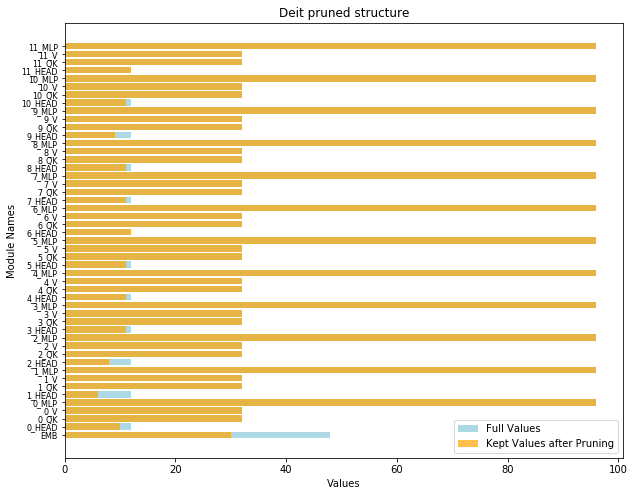

In [96]:
names = []
full_values = []
pruned_values = []

indices = list(range(variable_slices_by_type["EMB"][0], variable_slices_by_type["EMB"][1]))
cur_decision_vars = [model.decision_vars[k] for k in indices]
cur_decision_vars_value = [x.value for x in cur_decision_vars]
var_type = "EMB"
print("EMB", np.argmax(cur_decision_vars_value), all_variable_specs[var_type][2]-1)
names.append("EMB")
full_values.append(all_variable_specs[var_type][2])
pruned_values.append(np.argmax(cur_decision_vars_value)+1)

for block_id in range(BLOCK_NUMBER):
    for var_type, var_spec in all_variable_specs.items():
        if var_type == "EMB":
            continue
        indices = list(range(variable_slices_by_type[f"{block_id}_{var_type}"][0], variable_slices_by_type[f"{block_id}_{var_type}"][1]))
        cur_decision_vars = [model.decision_vars[k] for k in indices]
        cur_decision_vars_value = [x.value for x in cur_decision_vars]
        print(var_type, np.argmax(cur_decision_vars_value)+1, all_variable_specs[var_type][2])
        names.append(f"{block_id}_{var_type}")
        full_values.append(all_variable_specs[var_type][2])
        pruned_values.append(np.argmax(cur_decision_vars_value)+1)
        
plt.figure(figsize=(10, 8))  # Adjust the size as needed

# Plot full values
plt.barh(names, full_values, color='lightblue', label='Full Values')

# Plot pruned values
plt.barh(names, pruned_values, color='orange', alpha=0.7, label='Kept Values after Pruning')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Module Names')
plt.yticks(fontsize=8)
plt.title('Deit pruned structure')
plt.legend()

# Show the plot
plt.show()


In [ ]:
pruned_dims = {"EMB": 304, "HEAD": ""}

In [98]:
(48-29) * 16

304